# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [2]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

### Load Datasets

In [3]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2021-08-26 00:00:00+00:00,0,0.004,0.004,N,8.0,17.50,21.32,0.0,0.0,13.1,17.5,345.0,0,7.0,76.0,6.48
1,2021-08-26 01:00:00+00:00,0,0.004,0.004,N,8.0,17.10,19.41,0.0,0.0,13.0,17.1,341.0,0,7.0,77.0,6.12
2,2021-08-26 02:00:00+00:00,0,0.004,0.004,N,6.0,16.50,20.50,0.0,0.0,12.8,16.5,341.0,0,7.0,79.0,5.76
3,2021-08-26 03:00:00+00:00,0,0.004,0.004,N,6.0,15.80,20.58,0.0,0.0,12.6,15.8,342.0,0,7.0,81.0,5.40
4,2021-08-26 04:00:00+00:00,0,0.004,0.004,D,6.0,15.65,22.67,0.0,0.0,12.5,15.2,359.0,0,8.0,84.0,5.04


### Parse dates and check `NaNs`

In [4]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [5]:
#checking for missing values

def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_frame('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### Joining both datasets for a more in depht EDA

In [6]:
#joining both dfs for EDA
df = pd.concat([train_df, test_df], join="inner").sort_values("UTC Time").sort_values("Plant_ID")
df.shape

(235881, 17)

In [7]:
df.describe()

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,2.358810e+05,235881.000000,235881.000000,235881.000000
mean,7.670859,0.008685,0.008677,6.076560,11.535787,18.994054,10.469979,0.010241,6.796013,12.109901,143.582056,-3.277474e+06,9.581433,72.889347,7.436998
std,4.577249,0.014589,0.014576,1.945064,9.347031,8.756769,17.102289,0.040474,6.631462,8.387371,114.718993,8.383085e+07,4.858372,16.940525,2.438261
min,0.000000,0.000000,0.000000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.000000,4.000000,4.200000,14.000000,1.000000,0.000000,1.800000,5.500000,37.000000,0.000000e+00,7.000000,61.000000,5.760000
50%,8.000000,0.000000,0.000000,6.000000,9.960000,19.090000,4.000000,0.000000,6.200000,10.700000,112.000000,0.000000e+00,8.000000,77.000000,7.200000
75%,12.000000,0.012000,0.012000,8.000000,18.300000,23.260000,9.000000,0.000000,12.100000,18.300000,231.000000,0.000000e+00,15.000000,87.000000,8.640000
max,15.000000,0.097000,0.097000,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


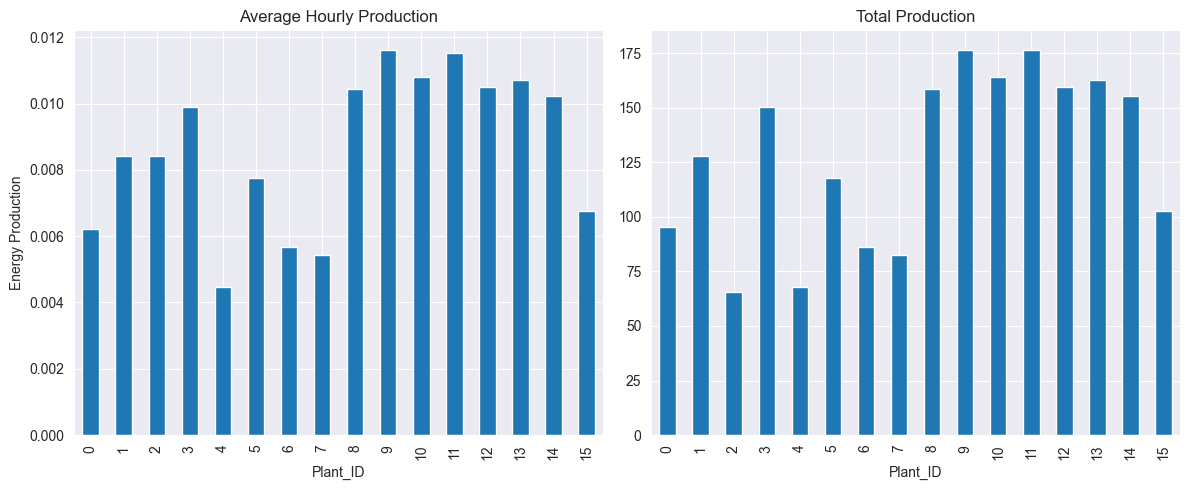

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

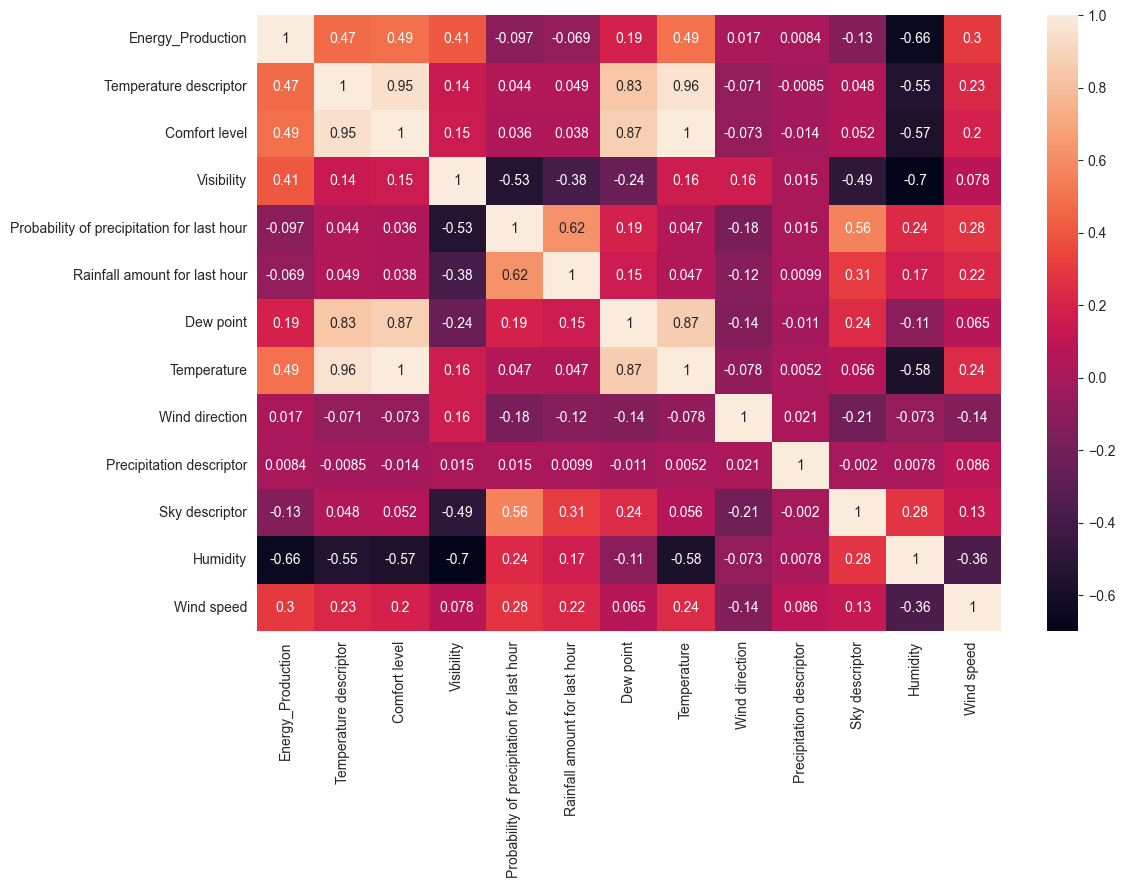

In [9]:
import seaborn as sns

corr = df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

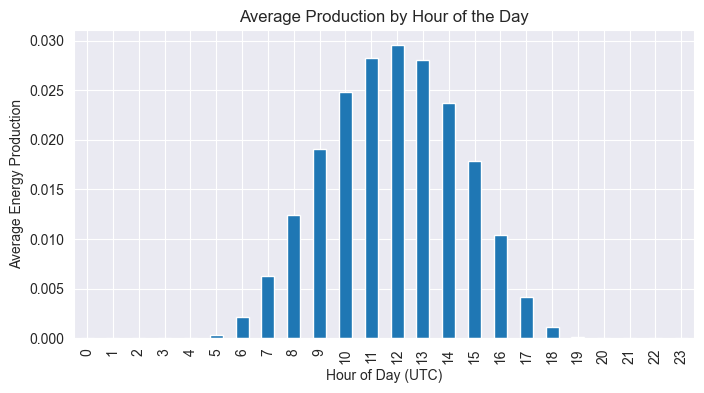

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['UTC Time'] = pd.to_datetime(df['UTC Time'])
df['hour'] = df['UTC Time'].dt.hour

(
    df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [11]:
plant_variance = (df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

,variance,std,mean,count
Plant_ID,,,,
9,0.000338,0.018372,0.011623,15191
11,0.000325,0.018034,0.011523,15311
13,0.000295,0.017163,0.010709,15191
10,0.000292,0.017080,0.010802,15191
8,0.000278,0.016684,0.010434,15191
12,0.000275,0.016571,0.010493,15191
14,0.000264,0.016245,0.010231,15191
3,0.000258,0.016059,0.009881,15191
1,0.000192,0.013864,0.008413,15191


# Part 2 Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations. This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

In [12]:
# Cyclical encoding: hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding: wind direction (degrees)
df['wind_dir_rad'] = np.deg2rad(df['Wind direction'])
df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
df['wind_dir_cos'] = np.cos(df['wind_dir_rad'])

# Drop intermediate column
df.drop(columns=['wind_dir_rad'], inplace=True)

In [13]:
# Ensure proper ordering
df = df.sort_values(['Plant_ID', 'UTC Time']).reset_index(drop=True)

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by `Plant_ID` and `UTC time`. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via a shift
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.


In [14]:
# Lagged energy production (allowed by instructions)
for lag in [1, 3, 6, 12, 24]:
    df[f'Energy_Production_lag_{lag}'] = (df.groupby('Plant_ID')['Energy_Production'].shift(lag))

In [15]:
# Rolling window features (past-only)
for window in [3, 6, 12, 24]:
    df[f'EP_roll_mean_{window}'] = (df.groupby('Plant_ID')['Energy_Production'].shift(1).rolling(window).mean())

    df[f'EP_roll_std_{window}'] = (df.groupby('Plant_ID')['Energy_Production'].shift(1).rolling(window).std())

### PCA on Weather Features

Weather variables exhibit strong multicollinearity.We apply Principal Component Analysis (PCA) to continuous weather features only.

Steps:
- Standardize all features
- Retain components explaining 95% of total variance
- Replace original weather variables with PCA components

This reduces dimensionality while preserving most of the information, and allows us to compare model performance with and without PCA.


In [16]:
weather_features = ['Temperature', 'Comfort level', 'Visibility', 'Probability of precipitation for last hour', 'Rainfall amount for last hour', 'Dew point', 'Humidity', 'Wind speed']

X_weather = df[weather_features].copy()

In [17]:
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

In [21]:
pca = PCA(n_components=0.95, random_state=13)
X_pca = pca.fit_transform(X_weather_scaled)

print(f"Original features: {X_weather.shape[1]}")
print(f"PCA components   : {X_pca.shape[1]}")

Original features: 8
PCA components   : 5


In [22]:
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = df.copy()

for i, col in enumerate(pca_cols):
    df_pca[col] = X_pca[:, i]

# Step 3 — Model Selection & Tuning

In this step we:
1. Build a leakage proof Train/Validation split (no shuffling, last 30% as validation).
2. Compare multiple model families:
   - Linear: Ridge, Lasso
   - Distance-based: KNN
   - Tree-based: Random Forest
   - Boosting: Gradient Boosting (baseline boosting)
3. Evaluate all models using:
   - RMSE (lower is better)
   - R² (higher is better)

We implement the two strategies:
- **Global Model**: one model trained on all plants using `Plant_ID` as a feature.
- **Local Models**: one model per `Plant_ID` (15 separate models), then aggregate performance.

In [23]:
# re-separating datasets
train_raw = train_df.copy()
test_raw  = test_df.copy()

# Ensure sorted for time  consistency
train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)

In [25]:
def add_time_and_cyclical_features(d):
    d = d.copy()
    d["UTC Time"] = pd.to_datetime(d["UTC Time"])
    d["hour"] = d["UTC Time"].dt.hour

    d["hour_sin"] = np.sin(2 * np.pi * d["hour"] / 24)
    d["hour_cos"] = np.cos(2 * np.pi * d["hour"] / 24)

    d["wind_dir_sin"] = np.sin(np.deg2rad(d["Wind direction"]))
    d["wind_dir_cos"] = np.cos(np.deg2rad(d["Wind direction"]))
    return d

def add_panel_lags_and_rolls(d, lags=(1,3,6,12,24), windows=(3,6,12,24)):
    d = d.copy()
    d = d.sort_values(["Plant_ID", "UTC Time"]).reset_index(drop=True)

    for lag in lags:
        d[f"Energy_Production_lag_{lag}"] = d.groupby("Plant_ID")["Energy_Production"].shift(lag)

    for w in windows:
        d[f"EP_roll_mean_{w}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(1).rolling(w).mean()
        )
        d[f"EP_roll_std_{w}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(1).rolling(w).std()
        )
    return d

train_feat = add_panel_lags_and_rolls(add_time_and_cyclical_features(train_raw))
test_feat  = add_panel_lags_and_rolls(add_time_and_cyclical_features(test_raw))


In [26]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

TARGET_COL = "Energy_Production"
BENCH_COL  = "Benchmark"
TIME_COL   = "UTC Time"

# Feature columns: drop target/benchmark/time
drop_cols = [TARGET_COL, BENCH_COL, TIME_COL]
feature_cols_eval = [c for c in train_feat.columns if c not in drop_cols]

# X/y
X_train = train_feat[feature_cols_eval].copy()
y_train = train_feat[TARGET_COL].copy()

X_test  = test_feat[feature_cols_eval].copy()
y_test  = test_feat[TARGET_COL].copy()

# Numeric/categorical split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Preprocess (same as your logic)
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ]
)

# Models + grids (your set)
models = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},
    "RandomForest": {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]},
    "GradBoost": {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]},
}

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_te
    )

# TimeSeries CV for tuning
tscv = TimeSeriesSplit(n_splits=3)

rows = []
test_predictions = {}  # store predictions for plotting later

for name, pipe in models.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    rmse_tr, r2_tr, rmse_te, r2_te, pred_te = eval_train_test(best, X_train, y_train, X_test, y_test)
    test_predictions[name] = pred_te

    rows.append({
        "model": name,
        "rmse_train": rmse_tr,
        "r2_train": r2_tr,
        "rmse_test": rmse_te,
        "r2_test": r2_te,
        "best_params": grid.best_params_
    })

results_all = pd.DataFrame(rows).sort_values("rmse_test").reset_index(drop=True)

# Benchmark metrics (train + test)
bench_train = np.clip(train_feat[BENCH_COL].values, 0, None)
bench_test  = np.clip(test_feat[BENCH_COL].values, 0, None)

bench_row = {
    "model": "Benchmark",
    "rmse_train": rmse(y_train, bench_train),
    "r2_train": float(r2_score(y_train, bench_train)),
    "rmse_test": rmse(y_test, bench_test),
    "r2_test": float(r2_score(y_test, bench_test)),
    "best_params": None
}

results_all = pd.concat([results_all, pd.DataFrame([bench_row])], ignore_index=True)
results_all = results_all.sort_values("rmse_test").reset_index(drop=True)

# Improvement vs benchmark on test
rmse_bench_test = bench_row["rmse_test"]
results_all["rmse_improve_vs_bench_%"] = 100 * (rmse_bench_test - results_all["rmse_test"]) / rmse_bench_test

display(results_all)

,model,rmse_train,r2_train,rmse_test,r2_test,best_params,rmse_improve_vs_bench_%
0,GradBoost,2.965536e-03,0.962875,0.002906,0.936147,"{'model__learning_rate': 0.1, 'model__max_dept...",58.871635
1,RandomForest,6.929199e-04,0.997973,0.002984,0.932706,"{'model__max_depth': None, 'model__n_estimator...",57.778064
2,Ridge,3.541788e-03,0.947045,0.003209,0.922153,{'model__alpha': 1.0},54.587886
3,Lasso,3.695247e-03,0.942357,0.003265,0.919406,{'model__alpha': 0.0001},53.793547
4,KNN,4.781329e-10,1.000000,0.003669,0.898222,"{'model__n_neighbors': 5, 'model__weights': 'd...",48.074831
5,Benchmark,7.659262e-03,0.752354,0.007067,0.622516,None,0.000000


In [37]:
RANDOM_STATE = 42

TARGET_COL = "Energy_Production"
TIME_COL   = "UTC Time"
PLANT_COL  = "Plant_ID"
BENCH_COL  = "Benchmark"

# 1) Time-safe split using 30% of df
df = df.sort_values([TIME_COL]).reset_index(drop=True)

split_idx = int(np.floor(0.70 * len(df)))
train_df = df.iloc[:split_idx].copy()
val_df   = df.iloc[split_idx:].copy()

print("Train:", train_df.shape, "| Val:", val_df.shape)

# 2) Build feature lists - Drop target and benchmark from features
drop_cols = [TARGET_COL, BENCH_COL]
feature_cols = [c for c in df.columns if c not in drop_cols]

# Identify numeric vs categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numeric features:", len(numeric_cols))
print("Categorical features:", categorical_cols)

# 3) Preprocessing blocks
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # needed for Ridge/Lasso/KNN; harmless for others
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ],
    remainder="drop"
)


# 4) Metrics helper
def evaluate_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    preds = np.clip(preds, 0, None)  # constraint: predictions >= 0

    rmse = np.sqrt(mean_squared_error(y_va, preds))
    r2   = r2_score(y_va, preds)

    return {"model": name, "rmse": rmse, "r2": r2}


Train: (165116, 35) | Val: (70765, 35)
Numeric features: 31
Categorical features: ['Day-Night']


In [38]:
# Global strategy: single model with Plant_ID included as feature

models = {
    "Ridge": Pipeline(steps=[
        ("prep", preprocess),
        ("model", Ridge(random_state=RANDOM_STATE))
    ]),
    "Lasso": Pipeline(steps=[
        ("prep", preprocess),
        ("model", Lasso(random_state=RANDOM_STATE, max_iter=20000))
    ]),
    "KNN": Pipeline(steps=[
        ("prep", preprocess),
        ("model", KNeighborsRegressor())
    ]),
    "RandomForest": Pipeline(steps=[
        ("prep", preprocess),
        ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "GradBoost": Pipeline(steps=[
        ("prep", preprocess),
        ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))
    ])
}

# Lightweight hyperparameter grids (keep it small to stay runnable)
param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},
    "RandomForest": {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]},
    "GradBoost": {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]}
}

results_global = []

for name, pipe in models.items():
    print(f"\nTraining (global) {name} ...")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    res = evaluate_model(f"Global-{name}", best_model, X_train, y_train, X_val, y_val)
    res["best_params"] = grid.best_params_
    results_global.append(res)

results_global_df = pd.DataFrame(results_global).sort_values("rmse")
display(results_global_df)


Training (global) Ridge ...

Training (global) Lasso ...

Training (global) KNN ...

Training (global) RandomForest ...

Training (global) GradBoost ...


,model,rmse,r2,best_params
4,Global-GradBoost,0.003095,0.939222,"{'model__learning_rate': 0.05, 'model__max_dep..."
3,Global-RandomForest,0.003107,0.938757,"{'model__max_depth': 10, 'model__n_estimators'..."
0,Global-Ridge,0.003333,0.929508,{'model__alpha': 0.1}
1,Global-Lasso,0.003397,0.926792,{'model__alpha': 0.0001}
2,Global-KNN,0.003582,0.918576,"{'model__n_neighbors': 30, 'model__weights': '..."


In [39]:
best_global_name = results_global_df.iloc[0]["model"].replace("Global-", "")
print("Best global family:", best_global_name)

best_family_pipe = models[best_global_name]
best_family_grid = param_grids[best_global_name]

Best global family: GradBoost


In [42]:
# Ensure panel-safe ordering within plant
df_panel = df.sort_values([PLANT_COL, TIME_COL]).reset_index(drop=True)

# Split by time globally (same split index) but keep plant ordering safe
train_panel = df_panel.iloc[:split_idx].copy()
val_panel   = df_panel.iloc[split_idx:].copy()

# Local results storage
local_scores = []

for plant_id in sorted(df_panel[PLANT_COL].unique()):
    tr_p = train_panel[train_panel[PLANT_COL] == plant_id]
    va_p = val_panel[val_panel[PLANT_COL] == plant_id]

    # If a plant has no validation rows (rare edge), skip
    if len(va_p) < 10 or len(tr_p) < 50:
        continue

    X_tr_p = tr_p[feature_cols].copy()
    y_tr_p = tr_p[TARGET_COL].copy()
    X_va_p = va_p[feature_cols].copy()
    y_va_p = va_p[TARGET_COL].copy()

    grid = GridSearchCV(
        estimator=best_family_pipe,
        param_grid=best_family_grid,
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_tr_p, y_tr_p)

    best_local_model = grid.best_estimator_

    preds = np.clip(best_local_model.predict(X_va_p), 0, None)
    rmse = np.sqrt(mean_squared_error(y_va_p, preds))
    r2   = r2_score(y_va_p, preds)

    local_scores.append({
        "Plant_ID": plant_id,
        "rmse": rmse,
        "r2": r2,
        "best_params": grid.best_params_
    })

local_scores_df = pd.DataFrame(local_scores).sort_values("rmse")
display(local_scores_df)

# Aggregate summary across plants (simple mean)
summary_local = {
    "model": f"Local-{best_global_name} (avg across plants)",
    "rmse": local_scores_df["rmse"].mean(),
    "r2": local_scores_df["r2"].mean()
}

summary_local_df = pd.DataFrame([summary_local])
display(summary_local_df)

,Plant_ID,rmse,r2,best_params
0,11,0.004074,0.937992,"{'model__learning_rate': 0.05, 'model__max_dep..."


,model,rmse,r2
0,Local-GradBoost (avg across plants),0.004074,0.937992


In [41]:
# ----------------------------
# Benchmark comparison on validation set
# ----------------------------
bench_val = val_df[BENCH_COL].values
bench_val = np.clip(bench_val, 0, None)

rmse_bench = np.sqrt(mean_squared_error(y_val, bench_val))
r2_bench   = r2_score(y_val, bench_val)

benchmark_df = pd.DataFrame([{"model": "Benchmark", "rmse": rmse_bench, "r2": r2_bench}])
display(benchmark_df)

,model,rmse,r2
0,Benchmark,0.009104,0.474136


In [43]:
final_table = pd.concat(
    [
        results_global_df[["model", "rmse", "r2"]],
        summary_local_df[["model", "rmse", "r2"]],
        benchmark_df[["model", "rmse", "r2"]]
    ],
    ignore_index=True
).sort_values("rmse")

display(final_table)

,model,rmse,r2
0,Global-GradBoost,0.003095,0.939222
1,Global-RandomForest,0.003107,0.938757
2,Global-Ridge,0.003333,0.929508
3,Global-Lasso,0.003397,0.926792
4,Global-KNN,0.003582,0.918576
5,Local-GradBoost (avg across plants),0.004074,0.937992
6,Benchmark,0.009104,0.474136


## Model Selection & Tuning (Global vs Local)

We compare two modeling strategies:

### 1) Global Model (single model with Plant_ID)
We train one model using all plants jointly, including Plant_ID as an input feature.
This allows the model to learn:
- common relationships between weather and production
- plant-level offsets (through Plant_ID)

**Pros:** more data, more stable learning
**Cons:** may underfit plant-specific behavior

### 2) Local Models (one model per plant)
We train 15 separate models, each using only its own plant history.
This can capture:
- plant-specific operational patterns
- heterogeneous sensitivity to weather

**Pros:** more tailored modeling
**Cons:** less data per plant → risk of instability / overfitting

### Evaluation (required metrics)
All models are evaluated on a **chronologically ordered validation set** (last 30% of training data),
using:
- **RMSE**: penalizes large errors; primary loss-like metric (lower is better)
- **R²**: explains variance relative to a constant baseline (higher is better)

### Final decision
We select the best approach by directly comparing RMSE and R² against:
- competing ML models
- the provided Benchmark (baseline)

This ensures the final conclusion answers the business question:
**Did ML actually add value beyond the benchmark?**